In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels as sm
from datetime import datetime, timedelta

from sklearn.model_selection import ParameterGrid

from utils import qualityMACAPE, qualityRMSE, \
InitExponentialSmoothing, AdaptiveExponentialSmoothing, WintersExponentialSmoothing

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'utils'

In [2]:
def MAE(x, predicted):
    return np.abs(x - predicted)

def MSE(x, predicted):
    return (x - predicted) ** 2

def exp_MAE(x, predicted):
    return np.exp(np.abs(x - predicted))

def exp_MSE(x, predicted):
    return np.exp((x - predicted) ** 2)

In [3]:
# Read data (time series)
ts = pd.read_csv('TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index

In [4]:
def base_algs_transformer(base_algs):
    new_algs = []
    for i in base_algs:
        for j in ParameterGrid(i['base_alg_params']):
            new_algs.append({'base_alg':i['base_alg'],
                            'base_alg_params':j})
    return new_algs

def get_preds(x, model):
    if np.isnan(x[-1]):
        fitted = pd.DataFrame(columns=['Values'], index=x.index).asfreq('D')
        fitted.loc[model.fittedvalues.index, 'Values'] = model.fittedvalues
        fitted.loc[model.fittedvalues.index[-1] + timedelta(days=1), 'Values'] = model.fcastvalues[0]
        fitted = fitted['Values']
        
        fcast = pd.DataFrame(index = pd.DatetimeIndex(start=(fitted.index)[-1], end=(fitted.index)[-1]+timedelta(days=1),
                                                  freq='D')[1:], columns=['Values'])
        fcast['Values'] = model.fcastvalues
        fcast = fcast['Values']
        
        first_not_nan = fitted[fitted.isna()==False].index[0]
        nan_indexes = fitted[first_not_nan:][fitted[first_not_nan:].isna()].index
        for i in nan_indexes:
            fitted[i] = fitted[i - timedelta(days=1)]
            
        return pd.concat([fitted, fcast])
    
    else:

        fitted = pd.DataFrame(columns=['Values'], index=x.index).asfreq('D')
        fitted.loc[model.fittedvalues.index, 'Values'] = model.fittedvalues
        fitted = fitted['Values']

        fcast = pd.DataFrame(index = pd.DatetimeIndex(start=(fitted.index)[-1], end=(fitted.index)[-1]+timedelta(days=1),
                                                  freq='D')[1:], columns=['Values'])
        fcast['Values'] = model.fcastvalues
        fcast = fcast['Values']

        first_not_nan = fitted[fitted.isna()==False].index[0]
        nan_indexes = fitted[first_not_nan:][fitted[first_not_nan:].isna()].index
        for i in nan_indexes:
            fitted[i] = fitted[i - timedelta(days=1)]

        return pd.concat([fitted, fcast])

# Aggregating Algorithm
* Descibe parameters of AA:
    - $\beta$ - parametr of mixability
    - $S(g)$ - substitution function
    - $p_j$ - initial distribution of base algorithms
d* Write down theoretical boundary for AA

In [5]:
def init_params(params):
    beta, w, ba = params['beta'], params['weights'], params['base_alg_params']
    N = len(ba)
    
    if w == 'equal':
        w = [1/N for i in range(N)]
    else:
        try:
            assert len(w) == N
        except AssertionError:
            print('initial weights should be either "equal" or an array of len(base_algs)')
    
    try:
        assert 0 < beta < 1
    except AssertionError:
        print ('beta must be set in the (0, 1) range')
    
    return beta, w, ba, N

def avoid_overflowing(base, power_array):
    maximum = np.max(power_array)
    minimum = np.min(power_array)
    
    pmax = -np.log(base)/np.log(2) * maximum
    pmin = -np.log(base)/np.log(2) * minimum
    
    if np.abs(pmax-pmin) > 2097:
        print('Overflow is imminent. Further calculations are not advised')
        return base ** power_array
    power_shift = abs((51+pmin+pmax)/2)
    power_shift = power_shift + min(0, pmin - power_shift + 1023)
    
    power_array = power_array - np.abs(power_shift * np.log(2) / np.log(base))
    
    return base ** power_array

def update_weights(curr_weights, init_weights, new_algs, active_algs, method='ver2'):
    if method == 'ver1':
        return init_weights[new_algs]
    elif method == 'ver2':
        return init_weights[new_algs] / np.sum(init_weights[active_algs])
    elif method == 'ver3':
        old_algs = np.logical_and((active_algs == True), (new_algs==False))
        return init_weights[new_algs] / np.sum(init_weights[old_algs])
    elif method == 'ver4':
        best_alg = curr_weights.argmax()
        return init_weights[new_algs] * curr_weights[best_alg] / init_weights[best_alg]
    elif method == 'ver5':
        worst_alg = curr_weights.argmin()
        return init_weights[new_algs] * curr_weights[worst_alg] / init_weights[worst_alg]
    elif method == 'ver6':
        old_algs = np.logical_and((active_algs == True), (new_algs==False))
        return init_weights[new_algs] * np.sum(curr_weights[old_algs]) / np.sum(init_weights[old_algs])

def get_weights(last_weights, beta, loss, control_overflowing=True):
    weights = np.log(beta) * loss
        
    if control_overflowing:
        res = avoid_overflowing(np.e, weights)
    else:
        res = np.exp(weights)
        
    res = res * last_weights
    res /= np.sum(res)
    return res

def count_y(data, t, method='minmax'):
    if method=='minmax':
        return (np.min(data[:t + 1]), np.max(data[:t + 1]))

def calc_g(Y, forecast, loss, weights, beta):
    
    g = np.sum(weights * np.power(beta, loss(Y, forecast)))
    g = np.log(g) / np.log(beta)
    
    if np.isinf(g):
        print('TTTTTT')        
    return g

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def upper_bound(current_loss, Y1, Y2, loss_func, M = 2, K = 2):
    if np.min(current_loss) == 0:
        current_loss[current_loss == 0] += 0.00000001
    if loss_func == 'MAE':
        alpha = np.sqrt((Y2 - Y1) * K * np.log(M) / (4 * np.min(current_loss)))
        L = (1 + alpha) * np.min(current_loss) + (1 + alpha) / alpha * (Y2 - Y1) * K / 4 * np.log(M)
    else:
        L = np.min(current_loss) + (np.square(Y2 - Y1))/2 * np.log(M)
        
    return L

def substituion_function(Y1, Y2, forecast, loss, weights, beta, method='v1'):
    gY1 = calc_g(Y1, forecast, loss, weights, beta)
    gY2 = calc_g(Y2, forecast, loss, weights, beta)
    
    if np.isinf(gY1):
        if np.isinf(gY2):
            return ((Y1+Y2)/2)
        else:
            return Y2
    elif np.isinf(gY2):
        return Y1
    
    if loss == MAE:
        if method == 'v1':
            y = (Y2 * gY1 + Y1 * gY2) / (gY1 + gY2)
        else:
            c = np.log(beta) / (2 * np.log(beta/2))
            y = c/2 * (gY1 - gY2) + (Y1 + Y2)/2
    elif loss==MSE:
        if method == 'v1':
            y = (Y2 * np.sqrt(gY1) + Y1 * np.sqrt(gY2)) / (np.sqrt(gY1) + np.sqrt(gY2))
        else:
            y = (gY1 - gY2) / (2 * (Y2 - Y1)) + (Y1 + Y2)/2
        
    return y

In [6]:
def aa_composition(x, h, params, loss_function = MAE, update_method='ver2', subst_method = 'v1'):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
    beta <scalar in [0,1]> - mixability parameter 
    weights <array in [0,1]> - initial weights of base_algs
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
    '''
    
    # internal params of composition
    beta, weights, base_algs, N = init_params(params)
    initial_weights = weights
    algs_prev_step = [False] * N
    T = len(x)
    
    AA_preds = [np.NaN]*(T+h)
    BA_preds = np.array([np.nan]*(T+h)*N).reshape(N, T+h) 
    
    #Getting the forecasts of basic algorithms
    for ba in range(len(base_algs)):
        if base_algs[ba]['base_alg'] == 'SARIMAX':
            model = SARIMAX(x, **(base_algs[ba]['base_alg_params'])).fit()
            preds = pd.concat([model.fittedvalues, model.forecast(h)])
        elif base_algs[ba]['base_alg'] == 'SimpleExpSmoothing':
            model = SimpleExpSmoothing(x.dropna()).fit(**(base_algs[ba]['base_alg_params']))
            preds = get_preds(x, model)

        BA_preds[ba] = preds
            

    loss, prev_loss = np.zeros(N), np.zeros(N)
    cum_loss = np.zeros(N)
    y = 1
    cum_ensemble_loss = 0
    ensemble_losses, bound = [], []
    
    for t in range(0, T):
        not_sleeping_algs = (np.isnan(BA_preds.T[t])==False)
        if not_sleeping_algs.sum() == 0:
            pass
        new_algs = np.logical_and(algs_prev_step==False, not_sleeping_algs==True)
        
        if new_algs.sum() != 0 and initial_weights != weights:
            weights[new_algs] = update_weights(weights, initial_weights, new_algs, not_sleeping_algs, method=update_method)
        
        if not np.isnan(x[t]):
            #Calculating the current losses for the moment t
            current_preds = BA_preds.transpose()[t][not_sleeping_algs]
            current_loss = loss_function(x[t], current_preds)
            loss[not_sleeping_algs] = current_loss
            cum_loss[not_sleeping_algs] += current_loss
            
            #Getting the weights
            weights = get_weights(weights, beta, prev_loss)

            #Calculating Y1/Y2
            Y1, Y2 = count_y(x, t)
            
            #Calculating the upper bound
            ub = upper_bound(cum_loss, Y1, Y2, loss_function)
            
            y = substituion_function(Y1, Y2, current_preds, loss_function, weights[not_sleeping_algs], beta, method=subst_method)

            ensemble_loss = loss_function(y, x[t])
            if (not np.isnan(ensemble_loss)):
                cum_ensemble_loss += ensemble_loss
            bound.append(ub)
            ensemble_losses.append(cum_ensemble_loss)
            
            prev_loss, loss  = loss, np.zeros(N)
            
        AA_preds[t+h] = y
        algs_prev_step = not_sleeping_algs
    return AA_preds, ensemble_losses, bound, BA_preds

In [8]:
# run (build forecast) Aggregating Algorithm

h =1 # forecast horizon

base_algs = base_algs_transformer([{'base_alg':'SARIMAX',
                                    'base_alg_params':{'order':[(1,1,0), (1,1,1), (2,1,1)],
                                                       'trend':['c', 't', None]}},
                                   {'base_alg':'SimpleExpSmoothing',
                                    'base_alg_params':{'smoothing_level':np.arange(0.1, 1.1, 0.1)}}
                                  ])

# define base algorithm
frc_ts = pd.DataFrame(index = ts.index.append(
    pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)
FRC_TS = dict()

beta = 0.9
bound_res = ensemble_losses_res = []
for cntr in ts.columns:
    frc_ts[cntr], ensemble_losses, bound, test = aa_composition(ts[cntr],h, 
                                  {'beta':0.9, 'weights': 'equal', 'base_alg_params':base_algs}, 
                                  loss_function = MAE, subst_method='v1')
    if (ensemble_losses != []):
        bound_res = bound
        ensemble_losses_res = ensemble_losses

        
FRC_TS['AA beta %.2f' % (beta)] = frc_ts

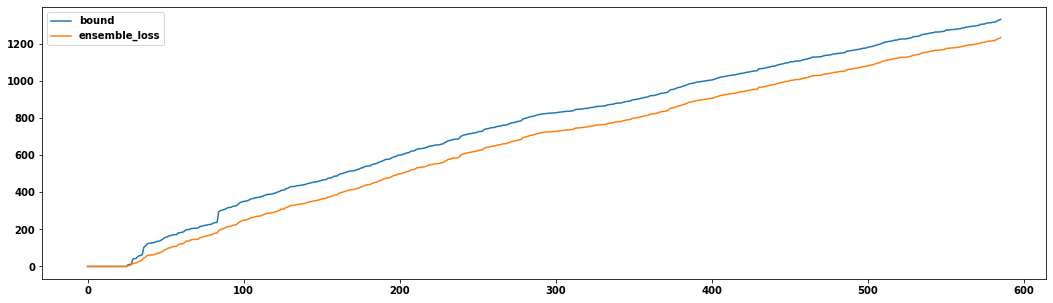

1234.002522181378


In [9]:
plt.figure(figsize=(18,5))
plt.plot(range(len(bound_res)), np.array(bound_res), label='bound')
plt.plot(range(len(ensemble_losses_res)), np.array(ensemble_losses_res), label='ensemble_loss')
plt.legend()
plt.show();
print(ensemble_losses_res[-1])

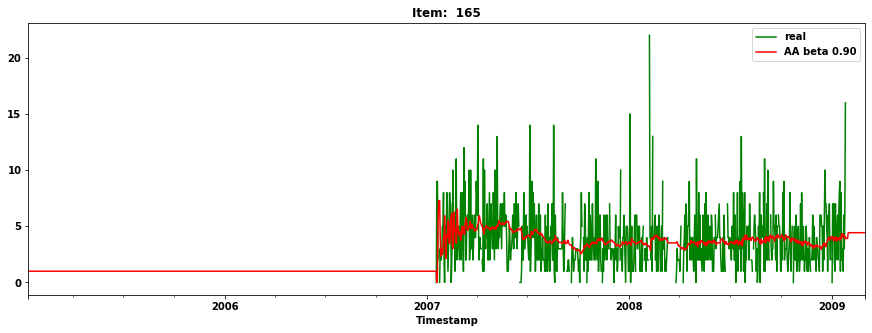

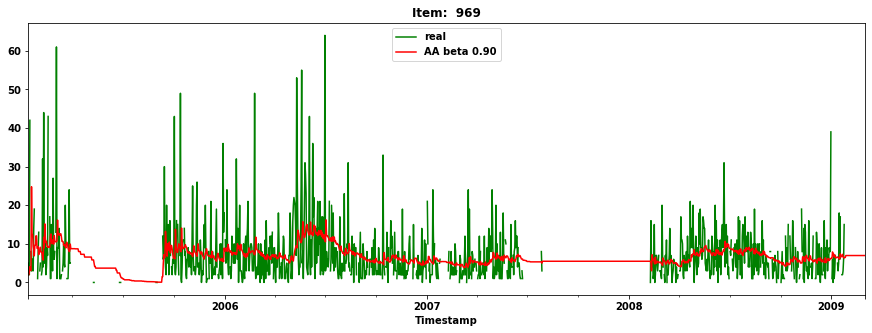

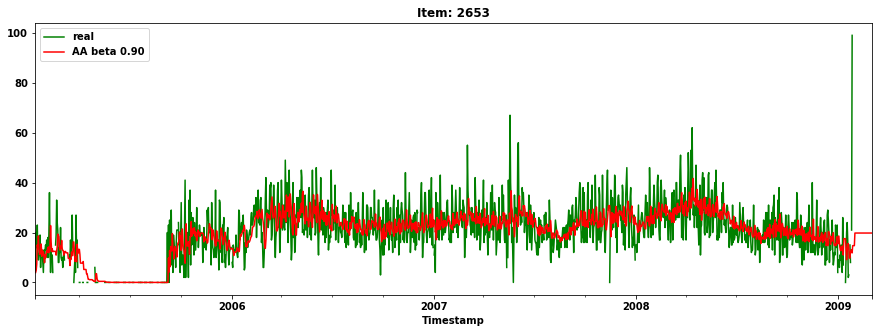

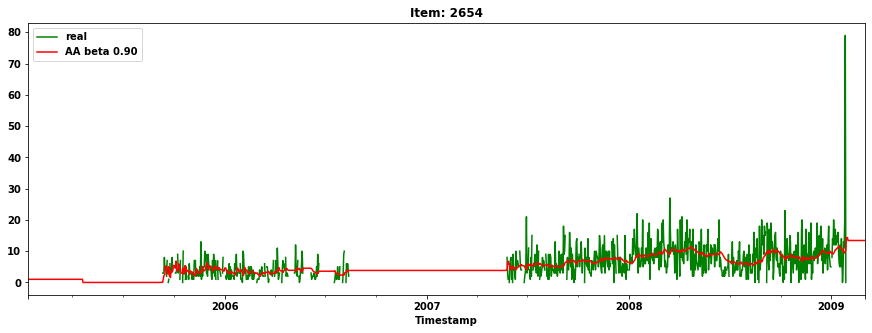

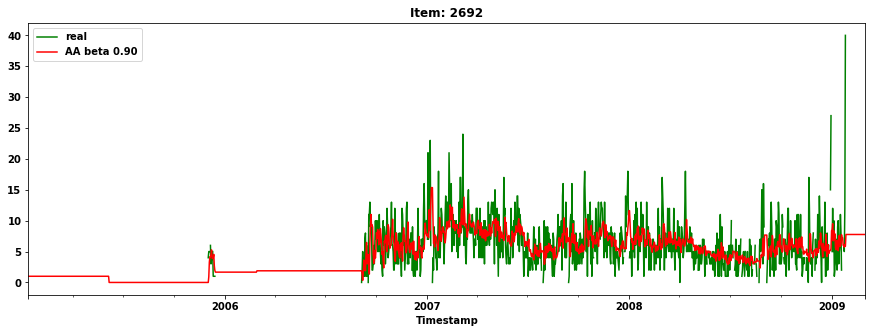

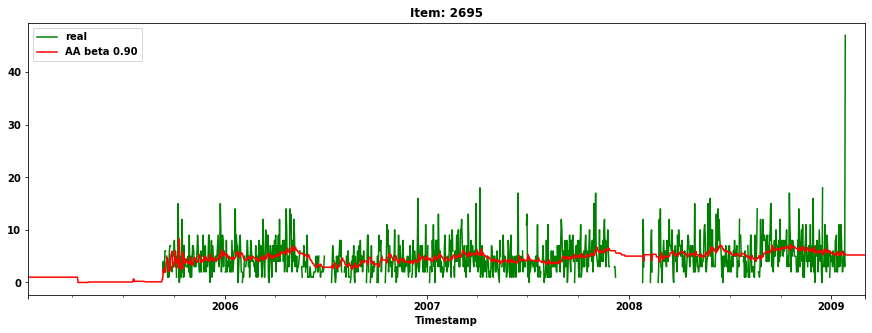

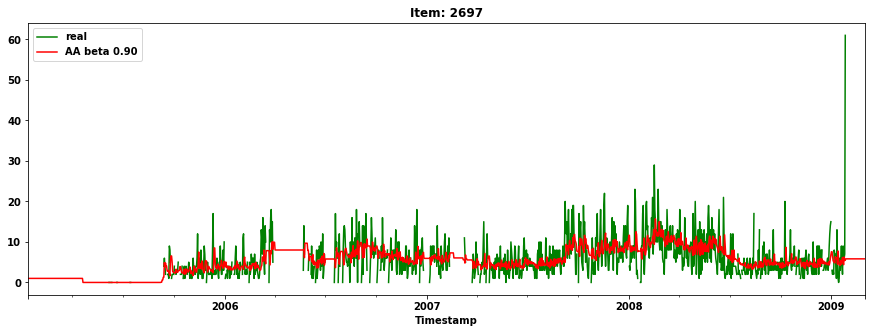

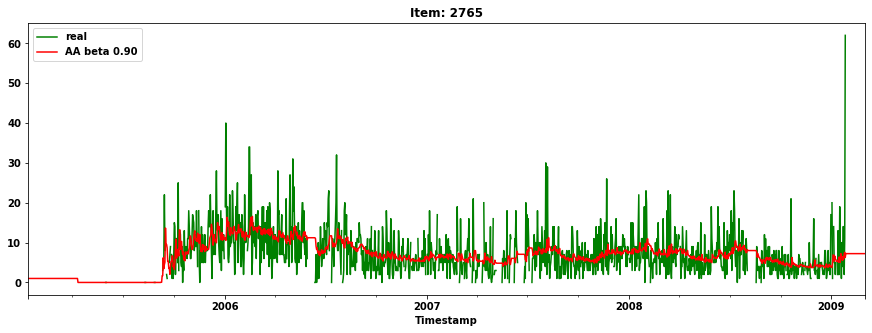

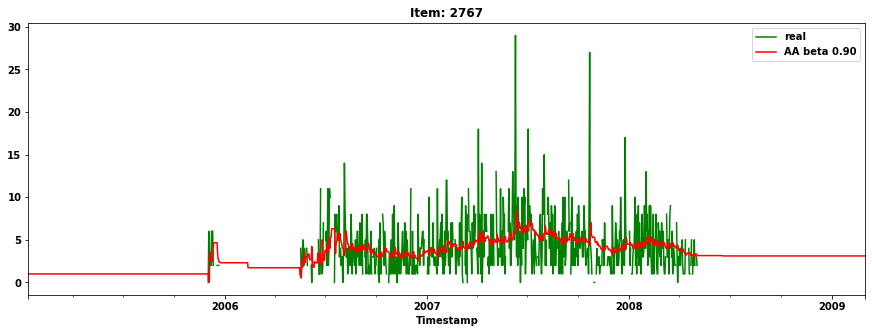

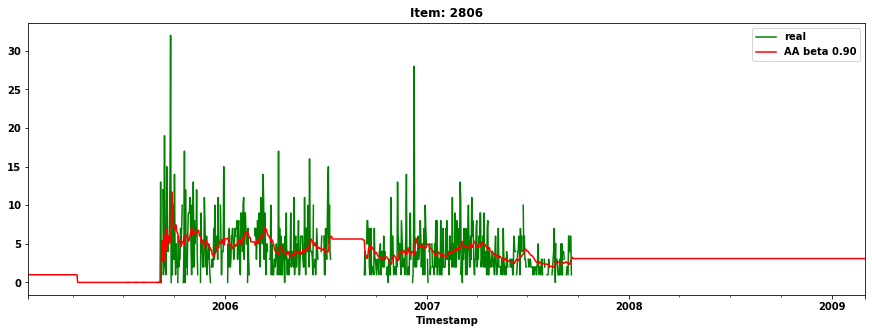

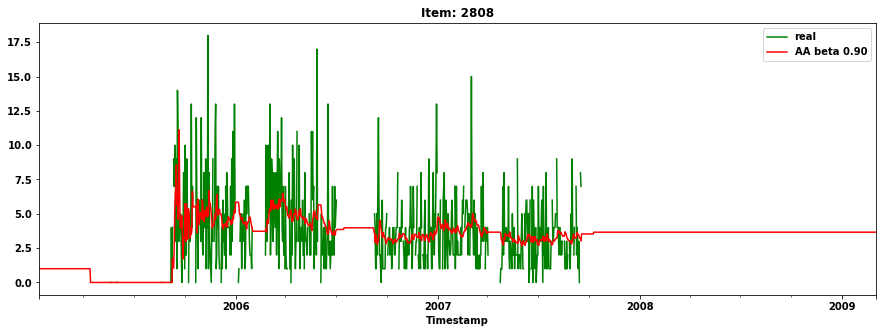

In [10]:
# draw forecast of Aggregating Algorithm
alg_name = 'AA beta 0.90'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()